In [ ]:
pip install niapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 116.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install numpy --upgrade --force-reinstall
!pip install pandas --upgrade --force-reinstall # Optional, but recommended

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
niapy 2.5.2 requires numpy<2.0.0,>=1.26.1, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.9 MB/s eta 0:00:00
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB

In [ ]:
import numpy as np
import pandas as pd
import torch
import ast  # For evaluating string representations of dictionaries
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import time
import datetime
import random
import torch.nn as nn
from tqdm import tqdm
"""
from niapy.algorithms.basic import HarrisHawksOptimization
from niapy.task import Task
from niapy.problems import Problem """
import copy
from torch.optim import AdamW

In [ ]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

from transformers import logging
logging.set_verbosity_error()

import os
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Define risk level to id mapping
risk_level_map = {
    'O': 0,  # No risk (Outside)
    'low': 1,
    'medium': 2,
    'high': 3
}

In [ ]:
# Inverse mapping for interpretation
id_to_risk_level = {v: k for k, v in risk_level_map.items()}

# Function to parse the RiskLevel column containing dictionaries
def parse_risk_level_dict(risk_dict_str):
    try:
        # Convert string representation of dictionary to actual dictionary
        return ast.literal_eval(risk_dict_str)
    except:
        # Return empty dict if there's an error parsing
        return {}

In [ ]:
# Load the dataset
try:
    # Try reading as Excel file first
    df = pd.read_excel("/content/LegalRiskDataset_Augmented.xlsx")
except:
    # If that fails, try CSV
    df = pd.read_csv("LegalRiskDataset.xlsx", on_bad_lines='skip')

print(f'Number of rows in dataset: {df.shape[0]}')
print(f'Columns in dataset: {df.columns.tolist()}')

# Display sample of the data
print("\nSample data:")
print(df.head(2))

Number of rows in dataset: 20000
Columns in dataset: ['Paragraph', 'RiskLevel']

Sample data:
                                           Paragraph  \
0  The Parties mutually agree that Contract shall...   
1  Each party acknowledges and agrees that it has...   

                                           RiskLevel  
0  {'mutually': 'low', 'terminated': 'high', 'Ter...  
1  {'acknowledges': 'medium', 'agrees': 'medium',...  


In [ ]:
# Parse the RiskLevel column to extract dictionaries
df['parsed_risk_levels'] = df['RiskLevel'].apply(parse_risk_level_dict)

# Function to tokenize text and create token-level labels
def tokenize_and_preserve_labels(text, risk_dict, tokenizer, max_length):
    """
    Tokenize each word and align labels with subword tokens
    """
    # Skip empty texts
    if not isinstance(text, str) or text.isspace():
        return None

    tokenized_inputs = tokenizer(
        text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_offsets_mapping=True,
        return_tensors='pt'
    )

    # Get offset mappings to map tokens back to words
    offset_mapping = tokenized_inputs.pop('offset_mapping')[0].tolist()

    # Create label list with same length as tokens, initialized with "O" (Outside) label
    labels = [0] * len(offset_mapping)  # 0 corresponds to "O"

    # Iterate through each word in the risk dictionary
    for risk_term, risk_level in risk_dict.items():
        # Skip if risk term is empty
        if not risk_term or risk_term.isspace():
            continue

        # Get risk level ID
        risk_id = risk_level_map.get(risk_level, 0)

        # Find all occurrences of the risk term in the text
        # Case insensitive search
        risk_term_lower = risk_term.lower()
        text_lower = text.lower()

        start_pos = 0
        while True:
            # Find the position of the risk term
            pos = text_lower.find(risk_term_lower, start_pos)
            if pos == -1:
                break

            # Calculate end position
            end_pos = pos + len(risk_term)

            # Find which tokens cover the risk term
            for i, (start, end) in enumerate(offset_mapping):
                # Skip special tokens (CLS, SEP, PAD)
                if start == 0 and end == 0:
                    continue

                # If token overlaps with risk term
                if (start < end_pos and end > pos):
                    labels[i] = risk_id

            # Move to search after this occurrence
            start_pos = end_pos

    return {
        'input_ids': tokenized_inputs['input_ids'][0],
        'attention_mask': tokenized_inputs['attention_mask'][0],
        'labels': torch.tensor(labels)
    }


In [ ]:
# Define a class for HHO optimization of BERT hyperparameters
class BertHyperparamOptimization:
    def __init__(self, train_dataset, val_dataset, tokenizer, device, num_labels=4):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.tokenizer = tokenizer
        self.device = device
        self.num_labels = num_labels
        self.best_f1 = 0
        self.best_params = None
        self.best_model = None
        self.param_names = [
            "learning_rate", "weight_decay", "dropout_rate", "attention_dropout",
            "warmup_ratio", "adam_epsilon", "max_grad_norm", "hidden_dropout"
        ]

    def __call__(self, params):
        # Clear CUDA cache before each run
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Extract hyperparameters from the solution vector
        learning_rate = params[0]
        weight_decay = params[1]
        dropout_rate = params[2]
        attention_dropout = params[3]
        warmup_ratio = params[4]
        adam_epsilon = params[5]
        max_grad_norm = params[6]
        hidden_dropout = params[7]

        print(f"\nEvaluating hyperparameters: lr={learning_rate:.2e}, wd={weight_decay:.6f}, " +
              f"do={dropout_rate:.2f}, ad={attention_dropout:.2f}, wr={warmup_ratio:.2f}, " +
              f"ae={adam_epsilon:.2e}, mgn={max_grad_norm:.2f}, hdo={hidden_dropout:.2f}")

        # Initialize model with the specified dropout rates
        model_config = {
            'hidden_dropout_prob': hidden_dropout,
            'attention_probs_dropout_prob': attention_dropout
        }

        # Model initialization with memory optimization
        with torch.cuda.amp.autocast():  # Use mixed precision
            model = AutoModelForTokenClassification.from_pretrained(
                "nlpaueb/legal-bert-base-uncased",
                num_labels=self.num_labels,
                output_attentions=False,
                output_hidden_states=False
            )
            model.config.hidden_dropout_prob = hidden_dropout
            model.config.attention_probs_dropout_prob = attention_dropout

        # Move model to device
        model.to(self.device)

        # Create train and validation dataloaders
        batch_size = 8  # Reduced from 16 to 8
        train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        validation_dataloader = DataLoader(self.val_dataset, batch_size=batch_size)

        # Set optimizer
        optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon, weight_decay=weight_decay)

        # Create the learning rate scheduler with warmup
        total_steps = len(train_dataloader) * 5  # 5 epochs for quick evaluation
        warmup_steps = int(warmup_ratio * total_steps)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        # Calculate class weights
        class_counts = [0] * self.num_labels
        total_tokens = 0

        for data_item in self.train_dataset.data:
            labels = data_item['labels']
            for label in labels:
                if label != -100:  # Skip padding
                    class_counts[label.item()] += 1
                    total_tokens += 1

        # Calculate weights (square root of inverse frequency)
        class_weights = [np.sqrt(total_tokens / (count + 1)) for count in class_counts]
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(self.device)

        # Create loss function
        loss_fct = FocalLoss(weight=class_weights, gamma=2.0, reduction='none')

        # Initialize mixed precision scaler
        scaler = torch.cuda.amp.GradScaler()

        # Training loop - just 5 epochs for quick evaluation
        for epoch_i in range(5):
            # Training
            model.train()
            total_loss = 0

            # Implement gradient accumulation steps
            accumulation_steps = 2  # Accumulate gradients over 2 batches

            for batch_idx, batch in enumerate(train_dataloader):
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Forward pass with mixed precision
                with torch.cuda.amp.autocast():
                    outputs = model(input_ids, attention_mask=attention_mask)
                    logits = outputs.logits

                    # Apply custom focal loss
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = logits.view(-1, self.num_labels)[active_loss]
                    active_labels = labels.view(-1)[active_loss]

                    # Calculate loss with focal loss
                    loss = loss_fct(active_logits, active_labels)
                    loss = loss.mean()  # Average the loss
                    loss = loss / accumulation_steps  # Normalize the loss

                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Update parameters after accumulation steps
                if (batch_idx + 1) % accumulation_steps == 0:
                    # Clip gradients
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                    # Update parameters
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()

                total_loss += loss.item() * accumulation_steps

                # Free up memory
                del input_ids, attention_mask, labels, outputs, logits, loss
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            # Evaluate on validation set
            model.eval()
            val_preds = []
            val_labels = []
            val_masks = []

            for batch in validation_dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                with torch.no_grad():
                    with torch.cuda.amp.autocast():
                        outputs = model(input_ids, attention_mask=attention_mask)
                        logits = outputs.logits

                val_preds.append(logits.detach().cpu().numpy())
                val_labels.append(labels.cpu().numpy())
                val_masks.append(attention_mask.cpu().numpy())

                # Free up memory
                del input_ids, attention_mask, labels, outputs, logits
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            # Concatenate predictions and labels
            all_val_preds = np.concatenate(val_preds, axis=0)
            all_val_labels = np.concatenate(val_labels, axis=0)
            all_val_masks = np.concatenate(val_masks, axis=0)

            # Compute entity-level metrics
            val_entity_metrics = compute_entity_metrics(all_val_preds, all_val_labels, all_val_masks)
            entity_f1 = val_entity_metrics['entity_f1']

            print(f"Epoch {epoch_i+1}/5 - Entity F1: {entity_f1:.4f}")

        # We want to maximize F1, but niapy minimizes, so return negative F1
        fitness = -entity_f1

        # Save the best model and parameters
        if entity_f1 > self.best_f1:
            self.best_f1 = entity_f1
            self.best_params = {
                "learning_rate": learning_rate,
                "weight_decay": weight_decay,
                "dropout_rate": dropout_rate,
                "attention_dropout": attention_dropout,
                "warmup_ratio": warmup_ratio,
                "adam_epsilon": adam_epsilon,
                "max_grad_norm": max_grad_norm,
                "hidden_dropout": hidden_dropout
            }
            # Save model state dict instead of full model
            self.best_model = copy.deepcopy(model.state_dict())

            print(f"New best F1: {entity_f1:.4f} with parameters:")
            for name, value in self.best_params.items():
                print(f"  {name}: {value}")

        # Clean up
        del model, optimizer, scheduler, loss_fct
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return fitness

def optimize_hyperparameters_with_hho():
    # Define parameter bounds
    dimension = 8  # Number of hyperparameters
    lower_bounds = [1e-6, 0.0, 0.1, 0.1, 0.0, 1e-8, 0.5, 0.1]  # Lower bounds for each parameter
    upper_bounds = [5e-4, 0.1, 0.5, 0.5, 0.2, 1e-6, 5.0, 0.5]  # Upper bounds for each parameter

    # Create fitness function with memory management modifications
    fitness_function = BertHyperparamOptimization(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        tokenizer=tokenizer,
        device=device
    )

    # Define a custom problem class
    class HyperparamProblem(Problem):
        def __init__(self, dimension, lower, upper, fitness_fn, *args, **kwargs):
            super().__init__(dimension, lower, upper, *args, **kwargs)
            self.fitness_fn = fitness_fn

        def _evaluate(self, solution):
            # Clear CUDA cache before each evaluation
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            return self.fitness_fn(solution)

    # Create the problem instance
    problem = HyperparamProblem(
        dimension=dimension,
        lower=lower_bounds,
        upper=upper_bounds,
        fitness_fn=fitness_function
    )

    # Create the task with our custom problem
    task = Task(problem=problem, max_iters=10)

    # Initialize HHO with parameters - reduce population size to save memory
    algorithm = HarrisHawksOptimization(
        population_size=5,
        seed=42  # For reproducibility
    )

    print("Starting Harris Hawks Optimization for hyperparameter tuning...")
    best_solution, best_fitness = algorithm.run(task)

    param_names = [
        "learning_rate", "weight_decay", "dropout_rate", "attention_dropout",
        "warmup_ratio", "adam_epsilon", "max_grad_norm", "hidden_dropout"
    ]

    print("\nOptimization complete!")
    print(f"Best Entity F1: {-best_fitness:.4f}")
    print("Best hyperparameters:")
    for i, param in enumerate(param_names):
        print(f"  {param}: {best_solution[i]}")

    return fitness_function.best_params, fitness_function.best_model

### Models Tried
###### RoBERTa: "roberta-base"
###### BERT: "bert-base-uncased"
###### DistilBERT: "distilbert-base-uncased"
###### ALBERT: "albert-base-v2"
###### ELECTRA: "google/electra-base-discriminator"
###### LEGAL-BERT: "nlpaueb/legal-bert-base-uncased"

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased", do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Set maximum sequence length
MAX_LEN = 256

# Process each paragraph with its corresponding risk dictionary
processed_data = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing data"):
    text = row['Paragraph']
    risk_dict = row['parsed_risk_levels']

    # Process the text and risk dictionary
    item = tokenize_and_preserve_labels(text, risk_dict, tokenizer, MAX_LEN)
    if item:  # Only add if not None
        processed_data.append(item)

print(f"Processed {len(processed_data)} valid paragraphs")

# Count labels in your dataset
label_counts = {id_to_risk_level[i]: 0 for i in range(len(risk_level_map))}

for item in processed_data:
    for label in item['labels']:
        label_counts[id_to_risk_level[label.item()]] += 1

total = sum(label_counts.values())
print("\nLabel distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({count/total*100:.2f}%)")

Processing data: 100%|██████████| 20000/20000 [00:49<00:00, 402.92it/s]


Processed 20000 valid paragraphs

Label distribution:
O: 4862401 (94.97%)
low: 81141 (1.58%)
medium: 102679 (2.01%)
high: 73779 (1.44%)


In [ ]:
# Split data into train and validation sets
train_data, val_data = train_test_split(processed_data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 16000
Validation set size: 4000


In [ ]:
# Create DataLoader for training
class RiskDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': self.data[idx]['input_ids'],
            'attention_mask': self.data[idx]['attention_mask'],
            'labels': self.data[idx]['labels']
        }

In [ ]:
# Create datasets and dataloaders
train_dataset = RiskDataset(train_data)
val_dataset = RiskDataset(val_data)

batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

validation_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
)

In [ ]:
# Load the Model
model = AutoModelForTokenClassification.from_pretrained(
    "nlpaueb/legal-bert-base-uncased",
    num_labels=len(risk_level_map),  # Number of risk levels + O tag
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU if available
model.to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# Calculate class weights using square root of inverse frequency
class_counts = [0] * len(risk_level_map)
total_tokens = 0

for data_item in train_data:
    labels = data_item['labels']
    for label in labels:
        if label != -100:  # Skip padding
            class_counts[label.item()] += 1
            total_tokens += 1

# Calculate weights (square root of inverse frequency for more moderate effect)
class_weights = [np.sqrt(total_tokens / (count + 1)) for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("\nClass weights:")
for i, weight in enumerate(class_weights):
    print(f"{id_to_risk_level[i]}: {weight.item():.4f}")


Class weights:
O: 1.0262
low: 7.9569
medium: 7.0483
high: 8.3115


In [ ]:
# Define Focal Loss for better handling of class imbalance
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = nn.functional.cross_entropy(
            input, target, weight=self.weight, reduction='none', label_smoothing=0.1)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
# Improved metrics function to compute token-level metrics
def compute_metrics(preds, labels, attention_mask):
    """
    Compute detailed metrics including per-class performance
    """
    # Convert predictions from logits to class ids
    preds = np.argmax(preds, axis=2)

    true_predictions = []
    true_labels = []

    for i in range(len(preds)):
        for j in range(len(preds[i])):
            # Skip padding tokens (where attention mask is 0)
            if attention_mask[i][j] == 1:
                true_predictions.append(preds[i][j])
                true_labels.append(labels[i][j])

    # Get detailed metrics for each class
    report = classification_report(true_labels, true_predictions,
                                   output_dict=True,
                                   target_names=list(id_to_risk_level.values()),
                                   zero_division=0)

    # Calculate overall metrics
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        true_labels, true_predictions, average='weighted', zero_division=0)

    overall_accuracy = accuracy_score(true_labels, true_predictions)

    # Calculate average metrics excluding the 'O' class
    non_o_classes = [k for k in report.keys() if k not in ['O', 'accuracy', 'macro avg', 'weighted avg']]
    if non_o_classes:
        non_o_f1 = sum(report[cls]['f1-score'] for cls in non_o_classes) / len(non_o_classes)
    else:
        non_o_f1 = 0.0

    return {
        'overall_accuracy': overall_accuracy,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'non_o_f1': non_o_f1,
        'class_report': report
    }

# Entity-level evaluation function
def compute_entity_metrics(preds, labels, attention_mask):
    """Compute metrics at the entity level rather than token level"""
    preds = np.argmax(preds, axis=2)

    true_entities = []
    pred_entities = []

    # Extract entity spans
    for i in range(len(preds)):
        # For gold labels
        gold_entities = []
        j = 0
        while j < len(labels[i]):
            if labels[i][j] != 0 and attention_mask[i][j] == 1:  # Not O and not padding
                label = labels[i][j]
                start = j
                while j < len(labels[i]) and labels[i][j] == label and attention_mask[i][j] == 1:
                    j += 1
                gold_entities.append((start, j-1, label))
            else:
                j += 1

        # For predicted labels
        pred_entities_sample = []
        j = 0
        while j < len(preds[i]):
            if preds[i][j] != 0 and attention_mask[i][j] == 1:  # Not O and not padding
                label = preds[i][j]
                start = j
                while j < len(preds[i]) and preds[i][j] == label and attention_mask[i][j] == 1:
                    j += 1
                pred_entities_sample.append((start, j-1, label))
            else:
                j += 1

        true_entities.extend([(i, s, e, l) for s, e, l in gold_entities])
        pred_entities.extend([(i, s, e, l) for s, e, l in pred_entities_sample])

    # Calculate metrics
    correct = 0
    for pred in pred_entities:
        if pred in true_entities:
            correct += 1

    precision = correct / len(pred_entities) if pred_entities else 0
    recall = correct / len(true_entities) if true_entities else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0

    return {
        'entity_precision': precision,
        'entity_recall': recall,
        'entity_f1': f1
    }

In [ ]:
# Run hyperparameter optimization with HHO
print("Running hyperparameter optimization with Harris Hawks Optimization...")
best_params, best_model = optimize_hyperparameters_with_hho()

# Use the optimized hyperparameters
learning_rate = best_params["learning_rate"]
weight_decay = best_params["weight_decay"]
dropout_rate = best_params["dropout_rate"]
attention_dropout = best_params["attention_dropout"]
warmup_ratio = best_params["warmup_ratio"]
adam_epsilon = best_params["adam_epsilon"]
max_grad_norm = best_params["max_grad_norm"]
hidden_dropout = best_params["hidden_dropout"]

print("\nTraining final model with optimized hyperparameters:")
for name, value in best_params.items():
    print(f"  {name}: {value}")

# Update model configuration with optimized dropout rates
model.config.hidden_dropout_prob = hidden_dropout
model.config.attention_probs_dropout_prob = attention_dropout
model.config.classifier_dropout = dropout_rate
# Update optimizer with optimized parameters
optimizer = AdamW(model.parameters(),
                  lr=learning_rate,
                  eps=adam_epsilon,
                  weight_decay=weight_decay)

Running hyperparameter optimization with Harris Hawks Optimization...
Starting Harris Hawks Optimization for hyperparameter tuning...

Evaluating hyperparameters: lr=3.87e-04, wd=0.043888, do=0.44, ad=0.38, wr=0.02, ae=9.76e-07, mgn=3.93, hdo=0.41
Epoch 1/5 - Entity F1: 0.0000
Epoch 2/5 - Entity F1: 0.0000
Epoch 3/5 - Entity F1: 0.0000
Epoch 4/5 - Entity F1: 0.0000
Epoch 5/5 - Entity F1: 0.0000

Evaluating hyperparameters: lr=6.49e-05, wd=0.045039, do=0.25, ad=0.47, wr=0.13, ae=8.25e-07, mgn=2.50, hdo=0.19
Epoch 1/5 - Entity F1: 0.7322
Epoch 2/5 - Entity F1: 0.7326
Epoch 3/5 - Entity F1: 0.7327
Epoch 4/5 - Entity F1: 0.7328
Epoch 5/5 - Entity F1: 0.7328
New best F1: 0.7328 with parameters:
  learning_rate: 6.492870270509738e-05
  weight_decay: 0.04503859378955671
  dropout_rate: 0.2483192096930325
  attention_dropout: 0.4707059955394407
  warmup_ratio: 0.12877302401613291
  adam_epsilon: 8.245339971381217e-07
  max_grad_norm: 2.49536389472299
  hidden_dropout: 0.19089548871391077

Eval

In [ ]:
learning_rate = 0.0001772801020081159
weight_decay = 0.039580735546444944
dropout_rate = 0.28852997292115395
attention_dropout = 0.17707821039175053
warmup_ratio = 0.029722463157423364
adam_epsilon = 5.003703750867259e-07
max_grad_norm = 1.5440996383829055
hidden_dropout = 0.36999716859586834

# Update model configuration with optimized dropout rates
model.config.hidden_dropout_prob = hidden_dropout
model.config.attention_probs_dropout_prob = attention_dropout
model.config.classifier_dropout = dropout_rate
# Update optimizer with optimized parameters
optimizer = AdamW(model.parameters(),
                  lr=learning_rate,
                  eps=adam_epsilon,
                  weight_decay=weight_decay)

In [ ]:
'''# Optimizer with lower learning rate
optimizer = AdamW(model.parameters(), lr=1e-5)'''

# Number of training epochs
epochs = 50

# Total number of training steps
total_steps = len(train_dataloader) * epochs


# Update scheduler with optimized warmup ratio
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(warmup_ratio * total_steps),
    num_training_steps=total_steps
)

In [ ]:
# Function to format time
def format_time(elapsed):
    '''Takes a time in seconds and returns a string hh:mm:ss'''
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Set random seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store training stats
train_loss_values = []
train_metrics_values = []
validation_loss_values = []
validation_metrics_values = []

# Track metrics for plotting
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_entity_f1 = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_entity_f1 = []

# Initialize best validation F1 for early stopping
best_val_f1 = 0
no_improvement = 0

# Create loss function
loss_fct = FocalLoss(weight=class_weights, gamma=2.0, reduction='none')

In [ ]:
def plot_confusion_matrices(all_train_preds, all_train_labels, all_train_masks, all_val_preds, all_val_labels, all_val_masks, id_to_risk_level):
    """
    Plot confusion matrices for both training and validation datasets.

    Args:
        all_train_preds: Predictions from the training set (logits)
        all_train_labels: True labels from the training set
        all_train_masks: Attention masks from the training set
        all_val_preds: Predictions from the validation set (logits)
        all_val_labels: True labels from the validation set
        all_val_masks: Attention masks from the validation set
        id_to_risk_level: Mapping from label IDs to risk level names
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Function to get predictions and true labels from logits
    def get_preds_and_labels(all_preds, all_labels, all_masks):
        # Convert logits to predictions
        predictions = np.argmax(all_preds, axis=2)

        # Flatten predictions and labels where mask is 1
        flat_preds = []
        flat_labels = []

        for i in range(len(predictions)):
            for j in range(len(predictions[i])):
                if all_masks[i][j] == 1:
                    flat_preds.append(predictions[i][j])
                    flat_labels.append(all_labels[i][j])

        return np.array(flat_preds), np.array(flat_labels)

    # Get flattened predictions and true labels
    train_preds_flat, train_labels_flat = get_preds_and_labels(all_train_preds, all_train_labels, all_train_masks)
    val_preds_flat, val_labels_flat = get_preds_and_labels(all_val_preds, all_val_labels, all_val_masks)

    # Get list of classes (sorted by ID for consistent order)
    classes = [id_to_risk_level[i] for i in sorted(id_to_risk_level.keys())]

    # Create figure with 1 row and 2 columns
    plt.figure(figsize=(20, 8))

    # Plot training confusion matrix
    plt.subplot(1, 2, 1)
    cm_train = confusion_matrix(train_labels_flat, train_preds_flat)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Training Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Plot validation confusion matrix
    plt.subplot(1, 2, 2)
    cm_val = confusion_matrix(val_labels_flat, val_preds_flat)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

In [ ]:
# Training loop
for epoch_i in range(0, epochs):
    # ========== TRAINING ==========
    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Progress update
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {elapsed}')

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits

        # Apply custom focal loss
        active_loss = attention_mask.view(-1) == 1
        active_logits = logits.view(-1, len(risk_level_map))[active_loss]
        active_labels = labels.view(-1)[active_loss]

        # Calculate loss with focal loss
        loss = loss_fct(active_logits, active_labels)
        loss = loss.mean()  # Average the loss

        # Accumulate loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update parameters
        optimizer.step()

        # Update learning rate schedule
        scheduler.step()

    # Calculate average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)

    # Evaluate on training data
    model.eval()
    train_preds = []
    train_labels = []
    train_masks = []

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        train_preds.append(logits.detach().cpu().numpy())
        train_labels.append(labels.cpu().numpy())
        train_masks.append(attention_mask.cpu().numpy())

    # Concatenate all predictions and labels
    all_train_preds = np.concatenate(train_preds, axis=0)
    all_train_labels = np.concatenate(train_labels, axis=0)
    all_train_masks = np.concatenate(train_masks, axis=0)

    # Compute token-level metrics
    train_metrics = compute_metrics(all_train_preds, all_train_labels, all_train_masks)

    # Compute entity-level metrics
    train_entity_metrics = compute_entity_metrics(all_train_preds, all_train_labels, all_train_masks)

    # Store for plotting
    train_loss_values.append(avg_train_loss)
    train_metrics_values.append(train_metrics)

    # Store metrics for plotting
    train_accuracy.append(train_metrics['overall_accuracy'])
    train_precision.append(train_metrics['overall_precision'])
    train_recall.append(train_metrics['overall_recall'])
    train_f1.append(train_metrics['overall_f1'])
    train_entity_f1.append(train_entity_metrics['entity_f1'])

    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training metrics:")
    print(f"    Overall accuracy: {train_metrics['overall_accuracy']:.4f}")
    print(f"    Overall precision: {train_metrics['overall_precision']:.4f}")
    print(f"    Overall recall: {train_metrics['overall_recall']:.4f}")
    print(f"    Overall F1 score: {train_metrics['overall_f1']:.4f}")
    print(f"    Entity-level F1: {train_entity_metrics['entity_f1']:.4f}")
    print(f"    Non-O F1 score: {train_metrics['non_o_f1']:.4f}")
    print("    Per-class metrics:")
    for cls_name, metrics in train_metrics['class_report'].items():
        if isinstance(metrics, dict) and cls_name in id_to_risk_level.values():
            print(f"      {cls_name}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")

    print(f"  Training epoch took: {format_time(time.time() - t0)}")

    # ========== VALIDATION ==========
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    eval_loss = 0
    val_preds = []
    val_labels = []
    val_masks = []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # No gradient calculation needed
        with torch.no_grad():
            # Forward pass
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

        loss = outputs.loss
        logits = outputs.logits

        # Accumulate loss
        eval_loss += loss.item()

        # Store predictions and labels
        val_preds.append(logits.detach().cpu().numpy())
        val_labels.append(labels.cpu().numpy())
        val_masks.append(attention_mask.cpu().numpy())

    # Concatenate all predictions and labels
    all_val_preds = np.concatenate(val_preds, axis=0)
    all_val_labels = np.concatenate(val_labels, axis=0)
    all_val_masks = np.concatenate(val_masks, axis=0)

    # Compute token-level metrics
    val_metrics = compute_metrics(all_val_preds, all_val_labels, all_val_masks)

    # Compute entity-level metrics
    val_entity_metrics = compute_entity_metrics(all_val_preds, all_val_labels, all_val_masks)

    # Calculate average validation loss
    avg_val_loss = eval_loss / len(validation_dataloader)

    # Store for plotting
    validation_loss_values.append(avg_val_loss)
    validation_metrics_values.append(val_metrics)

    # Store metrics for plotting
    val_accuracy.append(val_metrics['overall_accuracy'])
    val_precision.append(val_metrics['overall_precision'])
    val_recall.append(val_metrics['overall_recall'])
    val_f1.append(val_metrics['overall_f1'])
    val_entity_f1.append(val_entity_metrics['entity_f1'])

    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation metrics:")
    print(f"    Overall accuracy: {val_metrics['overall_accuracy']:.4f}")
    print(f"    Overall precision: {val_metrics['overall_precision']:.4f}")
    print(f"    Overall recall: {val_metrics['overall_recall']:.4f}")
    print(f"    Overall F1 score: {val_metrics['overall_f1']:.4f}")
    print(f"    Entity-level F1: {val_entity_metrics['entity_f1']:.4f}")
    print(f"    Non-O F1 score: {val_metrics['non_o_f1']:.4f}")
    print("    Per-class metrics:")
    for cls_name, metrics in val_metrics['class_report'].items():
        if isinstance(metrics, dict) and cls_name in id_to_risk_level.values():
            print(f"      {cls_name}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")

    print(f"  Validation took: {format_time(time.time() - t0)}")
    """

    # Check for early stopping
    current_val_f1 = val_entity_metrics['entity_f1']  # Using entity F1 for early stopping
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        no_improvement = 0
        # Save best model
        model.save_pretrained(f"legal_risk_ner_model_best")
        tokenizer.save_pretrained(f"legal_risk_ner_model_best")
        print(f"  New best model saved with entity F1: {best_val_f1:.4f}")
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f"Early stopping triggered after {epoch_i + 1} epochs")
            break """

print("")
print("Training complete!")

print("Plotting confusion matrices...")
plot_confusion_matrices(
    all_train_preds, all_train_labels, all_train_masks,
    all_val_preds, all_val_labels, all_val_masks,
    id_to_risk_level
)


======== Epoch 1 / 50 ========
Training...
  Average training loss: 2.8937
  Training metrics:
    Overall accuracy: 0.8776
    Overall precision: 0.9409
    Overall recall: 0.8776
    Overall F1 score: 0.8967
    Entity-level F1: 0.5596
    Non-O F1 score: 0.6274
    Per-class metrics:
      O: Precision=0.9977, Recall=0.8750, F1=0.9324
      low: Precision=0.4323, Recall=1.0000, F1=0.6037
      medium: Precision=0.3901, Recall=0.9167, F1=0.5473
      high: Precision=0.7264, Recall=0.7363, F1=0.7313
  Training epoch took: 0:00:07

Running Validation...
  Validation Loss: 0.6525
  Validation metrics:
    Overall accuracy: 0.8605
    Overall precision: 0.9307
    Overall recall: 0.8605
    Overall F1 score: 0.8827
    Entity-level F1: 0.5127
    Non-O F1 score: 0.5732
    Per-class metrics:
      O: Precision=0.9929, Recall=0.8625, F1=0.9231
      low: Precision=0.3963, Recall=0.9773, F1=0.5639
      medium: Precision=0.3588, Recall=0.8356, F1=0.5021
      high: Precision=0.6173, Recal

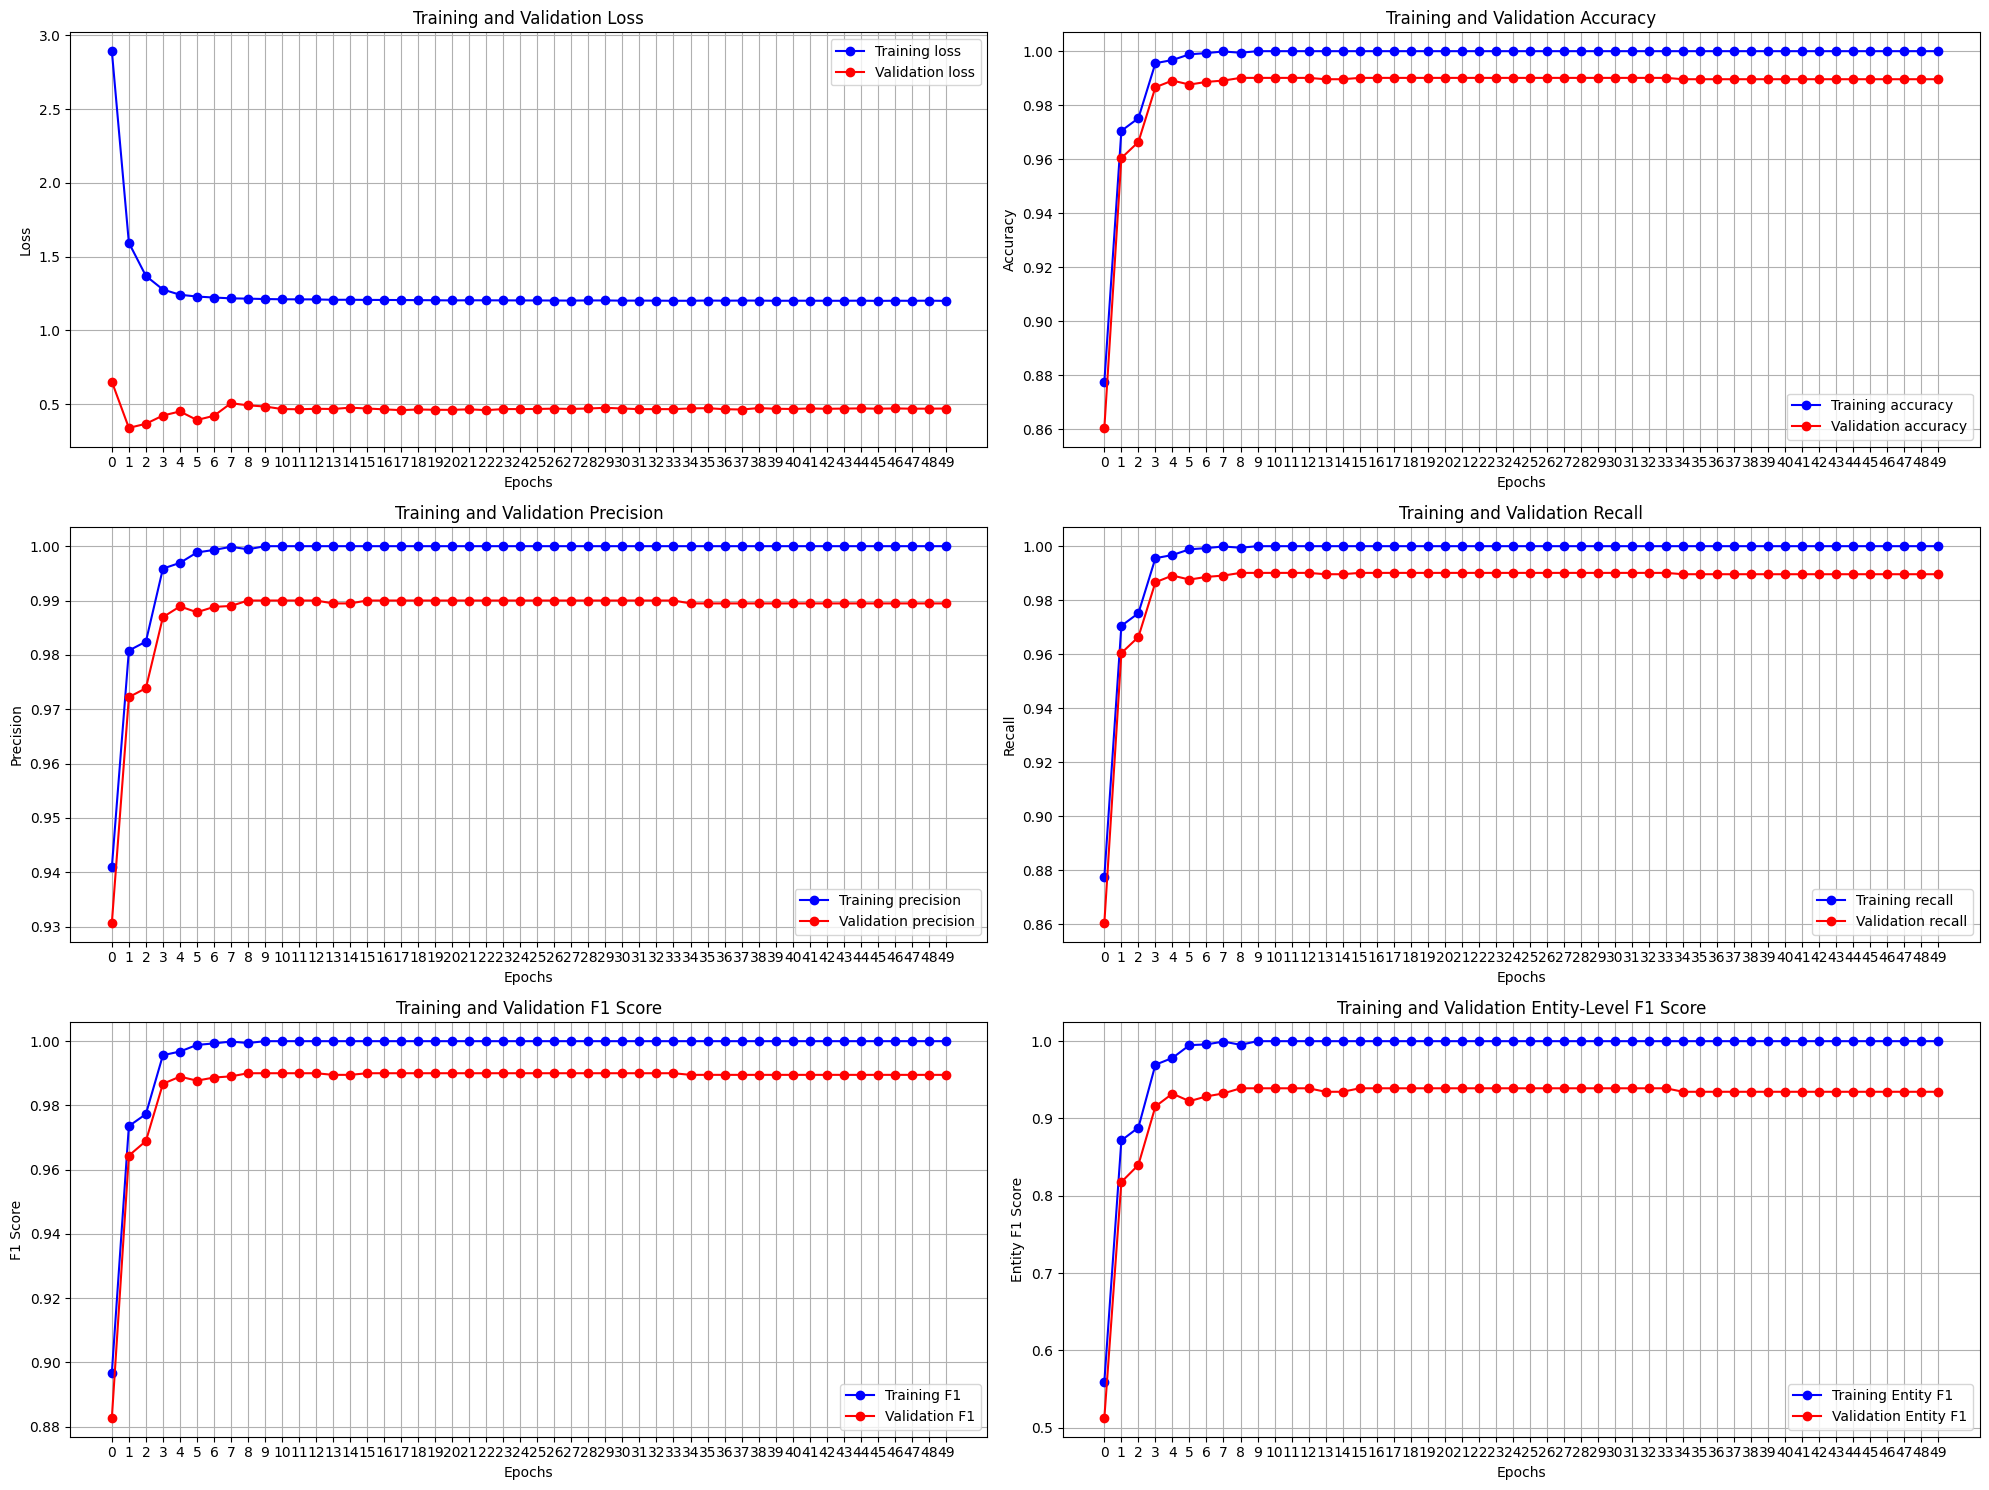

In [ ]:
# Create a 3x2 grid of plots
plt.figure(figsize=(20, 15))

# Plot 1: Training and Validation Loss
plt.subplot(3, 2, 1)
plt.plot(train_loss_values, 'b-o', label='Training loss')
plt.plot(validation_loss_values, 'r-o', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(len(train_loss_values)))
plt.grid(True)

# Plot 2: Training and Validation Accuracy
plt.subplot(3, 2, 2)
plt.plot(train_accuracy, 'b-o', label='Training accuracy')
plt.plot(val_accuracy, 'r-o', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(train_accuracy)))
plt.grid(True)

# Plot 3: Training and Validation Precision
plt.subplot(3, 2, 3)
plt.plot(train_precision, 'b-o', label='Training precision')
plt.plot(val_precision, 'r-o', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.xticks(range(len(train_precision)))
plt.grid(True)

# Plot 4: Training and Validation Recall
plt.subplot(3, 2, 4)
plt.plot(train_recall, 'b-o', label='Training recall')
plt.plot(val_recall, 'r-o', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.xticks(range(len(train_recall)))
plt.grid(True)

# Plot 5: Training and Validation F1 Score
plt.subplot(3, 2, 5)
plt.plot(train_f1, 'b-o', label='Training F1')
plt.plot(val_f1, 'r-o', label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.xticks(range(len(train_f1)))
plt.grid(True)

# Plot 6: Training and Validation Entity-Level F1 Score
plt.subplot(3, 2, 6)
plt.plot(train_entity_f1, 'b-o', label='Training Entity F1')
plt.plot(val_entity_f1, 'r-o', label='Validation Entity F1')
plt.title('Training and Validation Entity-Level F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Entity F1 Score')
plt.legend()
plt.xticks(range(len(train_entity_f1)))
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()



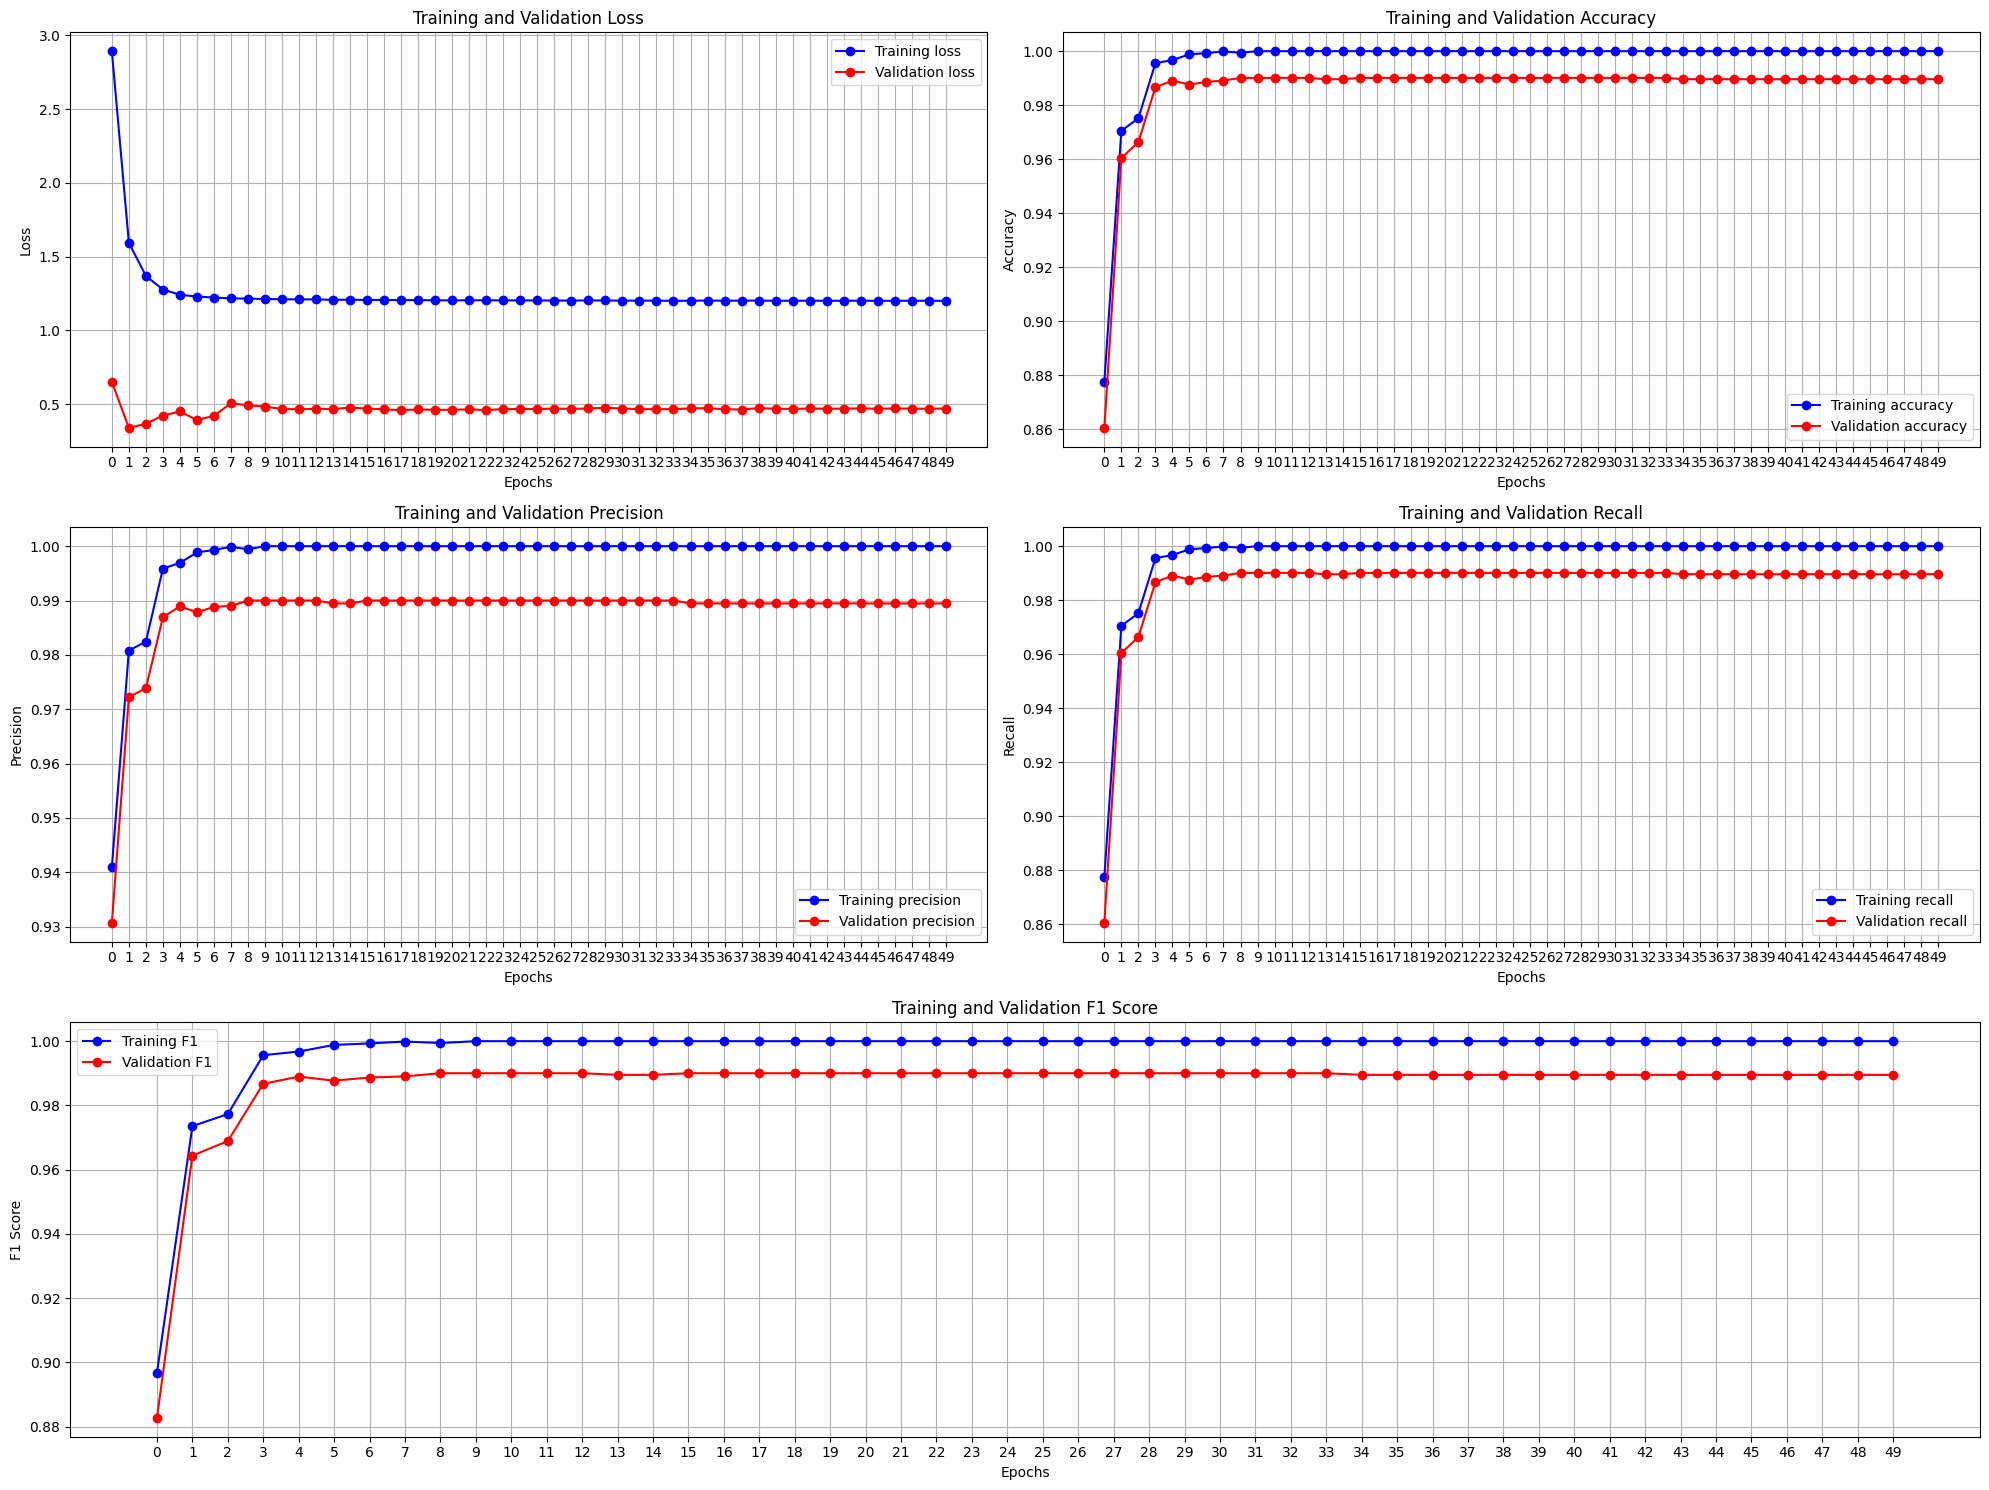

In [ ]:
# Create a new layout for 5 plots
plt.figure(figsize=(20, 15))

# Define grid specification with 3 rows, 2 columns
gs = plt.GridSpec(3, 2, figure=plt.gcf())

# Plot 1: Training and Validation Loss
ax1 = plt.subplot(gs[0, 0])
ax1.plot(train_loss_values, 'b-o', label='Training loss')
ax1.plot(validation_loss_values, 'r-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_xticks(range(len(train_loss_values)))
ax1.grid(True)

# Plot 2: Training and Validation Accuracy
ax2 = plt.subplot(gs[0, 1])
ax2.plot(train_accuracy, 'b-o', label='Training accuracy')
ax2.plot(val_accuracy, 'r-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_xticks(range(len(train_accuracy)))
ax2.grid(True)

# Plot 3: Training and Validation Precision
ax3 = plt.subplot(gs[1, 0])
ax3.plot(train_precision, 'b-o', label='Training precision')
ax3.plot(val_precision, 'r-o', label='Validation precision')
ax3.set_title('Training and Validation Precision')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Precision')
ax3.legend()
ax3.set_xticks(range(len(train_precision)))
ax3.grid(True)

# Plot 4: Training and Validation Recall
ax4 = plt.subplot(gs[1, 1])
ax4.plot(train_recall, 'b-o', label='Training recall')
ax4.plot(val_recall, 'r-o', label='Validation recall')
ax4.set_title('Training and Validation Recall')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Recall')
ax4.legend()
ax4.set_xticks(range(len(train_recall)))
ax4.grid(True)

# Plot 5: Training and Validation F1 Score (spanning both columns in row 3)
ax5 = plt.subplot(gs[2, :])
ax5.plot(train_f1, 'b-o', label='Training F1')
ax5.plot(val_f1, 'r-o', label='Validation F1')
ax5.set_title('Training and Validation F1 Score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 Score')
ax5.legend()
ax5.set_xticks(range(len(train_f1)))
ax5.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

In [ ]:
# Save the final model
model_save_path = "legal_risk_ner_model_final"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Final model saved to {model_save_path}")

# Load the best model for predictions
try:
    best_model = DebertaV2ForTokenClassification.from_pretrained("legal_risk_ner_model_best")
    best_model.to(device)
    print("Loaded best model for predictions")
except:
    best_model = model
    print("Using final model for predictions")

Final model saved to legal_risk_ner_model_final
Using final model for predictions


In [ ]:
# Improved prediction function with higher confidence threshold
def predict_risk_terms(text, model, tokenizer, confidence_threshold=0.7):
    """
    Predict risk terms and their levels for a given text with confidence scores
    """
    # Tokenize the text without padding or truncation for accurate offset mapping
    encoded_input = tokenizer(
        text,
        return_offsets_mapping=True,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        padding=False
    )

    offset_mapping = encoded_input.pop('offset_mapping')[0].tolist()
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Set model to evaluation mode
    model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get predictions and confidence scores
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(logits, dim=-1)[0].cpu().numpy()
    confidences = torch.max(probs, dim=-1)[0][0].cpu().numpy()

    # Extract risk terms with confidence filtering
    results = []
    i = 0
    while i < len(predictions):
        # If prediction is not "O" and confidence exceeds threshold
        if predictions[i] != 0 and confidences[i] >= confidence_threshold and i < len(offset_mapping):
            start_idx = offset_mapping[i][0]
            end_idx = offset_mapping[i][1]
            risk_level = id_to_risk_level[predictions[i]]
            conf = confidences[i]

            # Track current entity's positions
            entity_indices = [i]

            # Find the complete entity span (may consist of multiple tokens)
            j = i + 1
            while j < len(predictions) and predictions[j] == predictions[i]:
                end_idx = max(end_idx, offset_mapping[j][1])
                entity_indices.append(j)
                j += 1

            # Extract the actual text from the original input
            term = text[start_idx:end_idx]

            # Calculate average confidence across the entity
            avg_conf = np.mean([confidences[idx] for idx in entity_indices])

            results.append({
                'term': term,
                'risk_level': risk_level,
                'confidence': float(avg_conf),
                'start': int(start_idx),
                'end': int(end_idx)
            })

            i = j  # Skip to after this entity
        else:
            i += 1

    # Merge overlapping or adjacent terms with the same risk level
    merged_results = []
    if results:
        results.sort(key=lambda x: x['start'])
        current = results[0]

        for i in range(1, len(results)):
            if (results[i]['start'] <= current['end'] + 3 and  # Allow small gaps (3 chars)
                results[i]['risk_level'] == current['risk_level']):
                # Merge overlapping or adjacent terms
                current['end'] = max(current['end'], results[i]['end'])
                current['term'] = text[current['start']:current['end']]
                # Update confidence as weighted average
                current['confidence'] = (current['confidence'] + results[i]['confidence']) / 2
            else:
                # Add the current term to results an
                merged_results.append(current)
                current = results[i]

        # Don't forget to add the last term
        merged_results.append(current)

    return merged_results

In [ ]:
# Function to visualize risk term predictions on text
def visualize_risk_predictions(text, predictions):
    """
    Create a visualization of risk terms in text with color-coded highlighting
    """
    import html

    # Define colors for different risk levels
    risk_colors = {
        'low': '#FFEB3B',     # Yellow
        'medium': '#FF9800',  # Orange
        'high': '#F44336'     # Red
    }

    # Start with HTML template
    html_output = f"""
    <html>
    <head>
        <style>
            body {{ font-family: Arial, sans-serif; line-height: 1.6; }}
            .highlight-low {{ background-color: {risk_colors['low']}; }}
            .highlight-medium {{ background-color: {risk_colors['medium']}; }}
            .highlight-high {{ background-color: {risk_colors['high']}; }}
            .risk-term {{ position: relative; }}
            .risk-tooltip {{
                visibility: hidden;
                position: absolute;
                bottom: 100%;
                left: 50%;
                transform: translateX(-50%);
                background-color: #333;
                color: white;
                padding: 5px;
                border-radius: 3px;
                white-space: nowrap;
                z-index: 1;
            }}
            .risk-term:hover .risk-tooltip {{ visibility: visible; }}
        </style>
    </head>
    <body>
    <h2>Risk Analysis Results</h2>
    <div>
    """

    # Sort predictions by start position
    sorted_preds = sorted(predictions, key=lambda x: x['start'])

    # Process text with highlighting
    last_end = 0
    for pred in sorted_preds:
        # Add text before the prediction
        html_output += html.escape(text[last_end:pred['start']])

        # Add highlighted prediction with tooltip
        risk_level = pred['risk_level']
        confidence = pred['confidence'] * 100
        highlighted_text = f"""
        <span class="risk-term highlight-{risk_level}">
            {html.escape(pred['term'])}
            <span class="risk-tooltip">
                {risk_level.upper()} risk ({confidence:.1f}%)
            </span>
        </span>
        """
        html_output += highlighted_text

        last_end = pred['end']

    # Add remaining text
    html_output += html.escape(text[last_end:])

    # Close HTML tags
    html_output += """
    </div>
    </body>
    </html>
    """

    return html_output

In [ ]:
# Example usage with sample text
sample_text = """
This contract contains a provision that allows for immediate termination without notice
in case of any breach. Additionally, the non-compete clause restricts the employee from
working in similar industries for a period of 10 years after termination. The agreement
also includes a liability clause that makes the contractor responsible for all damages,
including those resulting from force majeure events. Payment terms require full payment
within 7 days of invoice receipt, with a 30% daily late fee.
"""

# Make predictions using the best model
predictions = predict_risk_terms(sample_text, best_model, tokenizer)

# Print the detected risk terms
print("Detected risk terms:")
for pred in predictions:
    print(f"Term: '{pred['term']}', Risk Level: {pred['risk_level']}, Confidence: {pred['confidence']:.2f}")

# Create a visualization of the predictions
html_visualization = visualize_risk_predictions(sample_text, predictions)

# Save the visualization to a file
with open("risk_visualization.html", "w") as f:
    f.write(html_visualization)


print("Visualization saved to risk_visualization.html")

Detected risk terms:
Term: ' termination', Risk Level: high, Confidence: 0.96
Term: ' notice', Risk Level: medium, Confidence: 0.96
Term: ' breach', Risk Level: high, Confidence: 0.96
Term: 'compete', Risk Level: high, Confidence: 0.72
Term: ' termination', Risk Level: high, Confidence: 0.96
Term: ' agreement', Risk Level: medium, Confidence: 0.96
Term: ' liability', Risk Level: high, Confidence: 0.93
Term: ' damages', Risk Level: high, Confidence: 0.96
Term: ' fee', Risk Level: high, Confidence: 0.94
Visualization saved to risk_visualization.html


In [ ]:
# Example usage with sample text
sample_text = """
The Parties mutually agree that Contract shall be terminated effective [date] ('the Termination Date').
[Optional: Except as expressly provided herein, the Contract will terminate according to the terms as
set forth therein.] Upon the Termination Date, the Contract shall have no further force or effect.
"""

# Make predictions using the best model
predictions = predict_risk_terms(sample_text, best_model, tokenizer)

# Print the detected risk terms
print("Detected risk terms:")
for pred in predictions:
    print(f"Term: '{pred['term']}', Risk Level: {pred['risk_level']}, Confidence: {pred['confidence']:.2f}")

# Create a visualization of the predictions
html_visualization = visualize_risk_predictions(sample_text, predictions)

# Save the visualization to a file
with open("risk_visualization.html", "w") as f:
    f.write(html_visualization)


print("Visualization saved to risk_visualization.html")

Detected risk terms:
Term: ' agree', Risk Level: medium, Confidence: 0.96
Term: ' terminated', Risk Level: high, Confidence: 0.96
Term: ' Termination', Risk Level: high, Confidence: 0.96
Term: ' terminate', Risk Level: high, Confidence: 0.94
Term: ' terms', Risk Level: medium, Confidence: 0.95
Term: ' Termination', Risk Level: high, Confidence: 0.96
Term: ' effect', Risk Level: medium, Confidence: 0.95
Visualization saved to risk_visualization.html


In [ ]:
# Example usage with sample text
sample_text = """
If either Party incurs any legal fees and/or costs and expenses in any proceeding to enforce the terms
of this Agreement or any of its rights provided hereunder, the prevailing Party shall be entitled to
recover its reasonable attorneys’ fees and any court, arbitration, mediation, or other litigation
expenses from the other Party.
"""

# Make predictions using the best model
predictions = predict_risk_terms(sample_text, best_model, tokenizer)

# Print the detected risk terms
print("Detected risk terms:")
for pred in predictions:
    print(f"Term: '{pred['term']}', Risk Level: {pred['risk_level']}, Confidence: {pred['confidence']:.2f}")

# Create a visualization of the predictions
html_visualization = visualize_risk_predictions(sample_text, predictions)

# Save the visualization to a file
with open("risk_visualization.html", "w") as f:
    f.write(html_visualization)


print("Visualization saved to risk_visualization.html")

Detected risk terms:
Term: ' fees', Risk Level: high, Confidence: 0.95
Term: ' costs', Risk Level: high, Confidence: 0.95
Term: ' expenses', Risk Level: high, Confidence: 0.88
Term: ' terms', Risk Level: medium, Confidence: 0.95
Term: ' Agreement', Risk Level: medium, Confidence: 0.96
Term: ' rights', Risk Level: medium, Confidence: 0.95
Term: ' fees', Risk Level: high, Confidence: 0.92
Term: ' court, arbitration, mediation', Risk Level: medium, Confidence: 0.93
Visualization saved to risk_visualization.html


In [ ]:
# Function to analyze a new legal document
def analyze_legal_document(file_path, model, tokenizer):
    """
    Analyze a legal document for risk terms
    """
    try:
        # Read the document
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        # Split text into manageable chunks (paragraphs)
        paragraphs = [p for p in text.split('\n\n') if p.strip()]

        all_predictions = []

        # Process each paragraph
        for i, para in enumerate(paragraphs):
            if len(para.strip()) < 10:  # Skip very short paragraphs
                continue

            print(f"Processing paragraph {i+1}/{len(paragraphs)}...")

            # Get predictions
            preds = predict_risk_terms(para, model, tokenizer)

            # Add paragraph index for reference
            for pred in preds:
                pred['paragraph_idx'] = i
                all_predictions.append(pred)

        # Count risk levels
        risk_counts = {'low': 0, 'medium': 0, 'high': 0}
        for pred in all_predictions:
            risk_counts[pred['risk_level']] += 1

        print("\nRisk Analysis Summary:")
        print(f"Total risk terms identified: {len(all_predictions)}")
        print(f"Low risk terms: {risk_counts['low']}")
        print(f"Medium risk terms: {risk_counts['medium']}")
        print(f"High risk terms: {risk_counts['high']}")

        # Create a combined visualization
        full_html = f"""
        <html>
        <head>
            <style>
                body {{ font-family: Arial, sans-serif; line-height: 1.6; }}
                .highlight-low {{ background-color: #FFEB3B; }}
                .highlight-medium {{ background-color: #FF9800; }}
                .highlight-high {{ background-color: #F44336; }}
                .risk-term {{ position: relative; }}
                .risk-tooltip {{
                    visibility: hidden;
                    position: absolute;
                    bottom: 100%;
                    left: 50%;
                    transform: translateX(-50%);
                    background-color: #333;
                    color: white;
                    padding: 5px;
                    border-radius: 3px;
                    white-space: nowrap;
                    z-index: 1;
                }}
                .risk-term:hover .risk-tooltip {{ visibility: visible; }}
                .summary {{
                    margin: 20px 0;
                    padding: 15px;
                    background-color: #f0f0f0;
                    border-radius: 5px;
                }}
                .para-container {{
                    border: 1px solid #ddd;
                    padding: 10px;
                    margin: 10px 0;
                    border-radius: 5px;
                }}
                h2, h3 {{ color: #333; }}
            </style>
        </head>
        <body>
            <h1>Legal Document Risk Analysis</h1>

            <div class="summary">
                <h2>Risk Summary</h2>
                <p>Total risk terms identified: {len(all_predictions)}</p>
                <p>Low risk terms: {risk_counts['low']}</p>
                <p>Medium risk terms: {risk_counts['medium']}</p>
                <p>High risk terms: {risk_counts['high']}</p>
            </div>
        """

        # Add each paragraph with its risk terms highlighted
        for i, para in enumerate(paragraphs):
            if len(para.strip()) < 10:
                continue

            para_preds = [p for p in all_predictions if p['paragraph_idx'] == i]

            # Skip paragraphs with no predictions if there are too many paragraphs
            if len(paragraphs) > 20 and not para_preds:
                continue

            # Create paragraph visualization
            last_end = 0
            para_html = f"<div class='para-container'><h3>Paragraph {i+1}</h3><div>"

            # Sort predictions by start position
            sorted_preds = sorted(para_preds, key=lambda x: x['start'])

            for pred in sorted_preds:
                # Add text before the prediction
                para_html += html.escape(para[last_end:pred['start']])

                # Add highlighted prediction with tooltip
                risk_level = pred['risk_level']
                confidence = pred['confidence'] * 100
                highlighted_text = f"""
                <span class="risk-term highlight-{risk_level}">
                    {html.escape(pred['term'])}
                    <span class="risk-tooltip">
                        {risk_level.upper()} risk ({confidence:.1f}%)
                    </span>
                </span>
                """
                para_html += highlighted_text

                last_end = pred['end']

            # Add remaining text
            para_html += html.escape(para[last_end:])
            para_html += "</div></div>"

            full_html += para_html

        # Close HTML tags
        full_html += """
        </body>
        </html>
        """

        # Save the visualization
        output_path = f"{file_path.split('.')[0]}_risk_analysis.html"
        with open(output_path, "w", encoding='utf-8') as f:
            f.write(full_html)

        print(f"\nRisk analysis saved to {output_path}")

        return all_predictions, output_path

    except Exception as e:
        print(f"Error analyzing document: {e}")
        return [], None

# Example usage of the document analyzer (commented out since we don't have a sample file)
# predictions, output_file = analyze_legal_document("sample_contract.txt", best_model, tokenizer)

print("Legal risk analysis model is ready for use!")

Legal risk analysis model is ready for use!


# **CLUSTERING INTEGRATION**

In [ ]:
!pip install hdbscan

In [ ]:
import numpy as np
import pandas as pd
import torch
import ast  # For evaluating string representations of dictionaries
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DebertaV2ForTokenClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import time
import datetime
import random
import torch.nn as nn
from tqdm import tqdm
import hdbscan

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Define risk level to id mapping
risk_level_map = {
    'O': 0,  # No risk (Outside)
    'low': 1,
    'medium': 2,
    'high': 3
}

# Inverse mapping for interpretation
id_to_risk_level = {v: k for k, v in risk_level_map.items()}

# Function to parse the RiskLevel column containing dictionaries
def parse_risk_level_dict(risk_dict_str):
    try:
        # Convert string representation of dictionary to actual dictionary
        return ast.literal_eval(risk_dict_str)
    except:
        # Return empty dict if there's an error parsing
        return {}

# Load the dataset
try:
    # Try reading as Excel file first
    df = pd.read_excel("/content/LegalRiskDataset_Augmented.xlsx")
except:
    # If that fails, try CSV
    df = pd.read_csv("/content/LegalRiskDataset_Augmented.xlsx", on_bad_lines='skip')

print(f'Number of rows in dataset: {df.shape[0]}')
print(f'Columns in dataset: {df.columns.tolist()}')

# Display sample of the data
print("\nSample data:")
print(df.head(2))

# Parse the RiskLevel column to extract dictionaries
df['parsed_risk_levels'] = df['RiskLevel'].apply(parse_risk_level_dict)

# Function to tokenize text and create token-level labels
def tokenize_and_preserve_labels(text, risk_dict, tokenizer, max_length):
    """
    Tokenize each word and align labels with subword tokens
    """
    # Skip empty texts
    if not isinstance(text, str) or text.isspace():
        return None

    tokenized_inputs = tokenizer(
        text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_offsets_mapping=True,
        return_tensors='pt'
    )

    # Get offset mappings to map tokens back to words
    offset_mapping = tokenized_inputs.pop('offset_mapping')[0].tolist()

    # Create label list with same length as tokens, initialized with "O" (Outside) label
    labels = [0] * len(offset_mapping)  # 0 corresponds to "O"

    # Iterate through each word in the risk dictionary
    for risk_term, risk_level in risk_dict.items():
        # Skip if risk term is empty
        if not risk_term or risk_term.isspace():
            continue

        # Get risk level ID
        risk_id = risk_level_map.get(risk_level, 0)

        # Find all occurrences of the risk term in the text
        # Case insensitive search
        risk_term_lower = risk_term.lower()
        text_lower = text.lower()

        start_pos = 0
        while True:
            # Find the position of the risk term
            pos = text_lower.find(risk_term_lower, start_pos)
            if pos == -1:
                break

            # Calculate end position
            end_pos = pos + len(risk_term)

            # Find which tokens cover the risk term
            for i, (start, end) in enumerate(offset_mapping):
                # Skip special tokens (CLS, SEP, PAD)
                if start == 0 and end == 0:
                    continue

                # If token overlaps with risk term
                if (start < end_pos and end > pos):
                    labels[i] = risk_id

            # Move to search after this occurrence
            start_pos = end_pos

    return {
        'input_ids': tokenized_inputs['input_ids'][0],
        'attention_mask': tokenized_inputs['attention_mask'][0],
        'labels': torch.tensor(labels)
    }

# Load the DeBERTa tokenizer
print('Loading LegalBert tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased", do_lower_case=True)

# Set maximum sequence length
MAX_LEN = 256

# Process each paragraph with its corresponding risk dictionary
processed_data = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing data"):
    text = row['Paragraph']
    risk_dict = row['parsed_risk_levels']

    # Process the text and risk dictionary
    item = tokenize_and_preserve_labels(text, risk_dict, tokenizer, MAX_LEN)
    if item:  # Only add if not None
        processed_data.append(item)

print(f"Processed {len(processed_data)} valid paragraphs")

# Count labels in your dataset
label_counts = {id_to_risk_level[i]: 0 for i in range(len(risk_level_map))}

for item in processed_data:
    for label in item['labels']:
        label_counts[id_to_risk_level[label.item()]] += 1

total = sum(label_counts.values())
print("\nLabel distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({count/total*100:.2f}%)")

# Split data into train and validation sets
train_data, val_data = train_test_split(processed_data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

# Create DataLoader for training
class RiskDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': self.data[idx]['input_ids'],
            'attention_mask': self.data[idx]['attention_mask'],
            'labels': self.data[idx]['labels']
        }

# Create datasets and dataloaders
train_dataset = RiskDataset(train_data)
val_dataset = RiskDataset(val_data)

batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

validation_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
)

# Load LegalBert model for token classification
model = AutoModelForTokenClassification.from_pretrained(
    "nlpaueb/legal-bert-base-uncased",
    num_labels=len(risk_level_map),  # Number of risk levels + O tag
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU if available
model.to(device)

# Calculate class weights using square root of inverse frequency
class_counts = [0] * len(risk_level_map)
total_tokens = 0

for data_item in train_data:
    labels = data_item['labels']
    for label in labels:
        if label != -100:  # Skip padding
            class_counts[label.item()] += 1
            total_tokens += 1

# Calculate weights (square root of inverse frequency for more moderate effect)
class_weights = [np.sqrt(total_tokens / (count + 1)) for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("\nClass weights:")
for i, weight in enumerate(class_weights):
    print(f"{id_to_risk_level[i]}: {weight.item():.4f}")

# Define Focal Loss for better handling of class imbalance
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = nn.functional.cross_entropy(
            input, target, weight=self.weight, reduction='none', label_smoothing=0.1)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Optimizer with lower learning rate
optimizer = AdamW(model.parameters(), lr=1e-5)

# Number of training epochs
epochs = 15

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler with warmup
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

# Improved metrics function to compute token-level metrics
def compute_metrics(preds, labels, attention_mask):
    """
    Compute detailed metrics including per-class performance
    """
    # Convert predictions from logits to class ids
    preds = np.argmax(preds, axis=2)

    true_predictions = []
    true_labels = []

    for i in range(len(preds)):
        for j in range(len(preds[i])):
            # Skip padding tokens (where attention mask is 0)
            if attention_mask[i][j] == 1:
                true_predictions.append(preds[i][j])
                true_labels.append(labels[i][j])

    # Get detailed metrics for each class
    report = classification_report(true_labels, true_predictions,
                                   output_dict=True,
                                   target_names=list(id_to_risk_level.values()),
                                   zero_division=0)

    # Calculate overall metrics
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        true_labels, true_predictions, average='weighted', zero_division=0)

    overall_accuracy = accuracy_score(true_labels, true_predictions)

    # Calculate average metrics excluding the 'O' class
    non_o_classes = [k for k in report.keys() if k not in ['O', 'accuracy', 'macro avg', 'weighted avg']]
    if non_o_classes:
        non_o_f1 = sum(report[cls]['f1-score'] for cls in non_o_classes) / len(non_o_classes)
    else:
        non_o_f1 = 0.0

    return {
        'overall_accuracy': overall_accuracy,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'non_o_f1': non_o_f1,
        'class_report': report
    }

# Entity-level evaluation function
def compute_entity_metrics(preds, labels, attention_mask):
    """Compute metrics at the entity level rather than token level"""
    preds = np.argmax(preds, axis=2)

    true_entities = []
    pred_entities = []

    # Extract entity spans
    for i in range(len(preds)):
        # For gold labels
        gold_entities = []
        j = 0
        while j < len(labels[i]):
            if labels[i][j] != 0 and attention_mask[i][j] == 1:  # Not O and not padding
                label = labels[i][j]
                start = j
                while j < len(labels[i]) and labels[i][j] == label and attention_mask[i][j] == 1:
                    j += 1
                gold_entities.append((start, j-1, label))
            else:
                j += 1

        # For predicted labels
        pred_entities_sample = []
        j = 0
        while j < len(preds[i]):
            if preds[i][j] != 0 and attention_mask[i][j] == 1:  # Not O and not padding
                label = preds[i][j]
                start = j
                while j < len(preds[i]) and preds[i][j] == label and attention_mask[i][j] == 1:
                    j += 1
                pred_entities_sample.append((start, j-1, label))
            else:
                j += 1

        true_entities.extend([(i, s, e, l) for s, e, l in gold_entities])
        pred_entities.extend([(i, s, e, l) for s, e, l in pred_entities_sample])

    # Calculate metrics
    correct = 0
    for pred in pred_entities:
        if pred in true_entities:
            correct += 1

    precision = correct / len(pred_entities) if pred_entities else 0
    recall = correct / len(true_entities) if true_entities else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0

    return {
        'entity_precision': precision,
        'entity_recall': recall,
        'entity_f1': f1
    }

# Function to format time
def format_time(elapsed):
    '''Takes a time in seconds and returns a string hh:mm:ss'''
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Set random seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store training stats
train_loss_values = []
train_metrics_values = []
validation_loss_values = []
validation_metrics_values = []

# Track metrics for plotting
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_entity_f1 = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_entity_f1 = []

# Initialize best validation F1 for early stopping
best_val_f1 = 0
patience = 3
no_improvement = 0

# Create loss function
loss_fct = FocalLoss(weight=class_weights, gamma=2.0, reduction='none')

# Training loop
for epoch_i in range(0, epochs):
    # ========== TRAINING ==========
    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Progress update
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {elapsed}')

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits

        # Apply custom focal loss
        active_loss = attention_mask.view(-1) == 1
        active_logits = logits.view(-1, len(risk_level_map))[active_loss]
        active_labels = labels.view(-1)[active_loss]

        # Calculate loss with focal loss
        loss = loss_fct(active_logits, active_labels)
        loss = loss.mean()  # Average the loss

        # Accumulate loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update learning rate schedule
        scheduler.step()

    # Calculate average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)

    # Evaluate on training data
    model.eval()
    train_preds = []
    train_labels = []
    train_masks = []

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        train_preds.append(logits.detach().cpu().numpy())
        train_labels.append(labels.cpu().numpy())
        train_masks.append(attention_mask.cpu().numpy())

    # Concatenate all predictions and labels
    all_train_preds = np.concatenate(train_preds, axis=0)
    all_train_labels = np.concatenate(train_labels, axis=0)
    all_train_masks = np.concatenate(train_masks, axis=0)

    # Compute token-level metrics
    train_metrics = compute_metrics(all_train_preds, all_train_labels, all_train_masks)

    # Compute entity-level metrics
    train_entity_metrics = compute_entity_metrics(all_train_preds, all_train_labels, all_train_masks)

    # Store for plotting
    train_loss_values.append(avg_train_loss)
    train_metrics_values.append(train_metrics)

    # Store metrics for plotting
    train_accuracy.append(train_metrics['overall_accuracy'])
    train_precision.append(train_metrics['overall_precision'])
    train_recall.append(train_metrics['overall_recall'])
    train_f1.append(train_metrics['overall_f1'])
    train_entity_f1.append(train_entity_metrics['entity_f1'])

    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training metrics:")
    print(f"    Overall accuracy: {train_metrics['overall_accuracy']:.4f}")
    print(f"    Overall precision: {train_metrics['overall_precision']:.4f}")
    print(f"    Overall recall: {train_metrics['overall_recall']:.4f}")
    print(f"    Overall F1 score: {train_metrics['overall_f1']:.4f}")
    print(f"    Entity-level F1: {train_entity_metrics['entity_f1']:.4f}")
    print(f"    Non-O F1 score: {train_metrics['non_o_f1']:.4f}")
    print("    Per-class metrics:")
    for cls_name, metrics in train_metrics['class_report'].items():
        if isinstance(metrics, dict) and cls_name in id_to_risk_level.values():
            print(f"      {cls_name}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")

    print(f"  Training epoch took: {format_time(time.time() - t0)}")

    # ========== VALIDATION ==========
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    eval_loss = 0
    val_preds = []
    val_labels = []
    val_masks = []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # No gradient calculation needed
        with torch.no_grad():
            # Forward pass
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

        loss = outputs.loss
        logits = outputs.logits

        # Accumulate loss
        eval_loss += loss.item()

        # Store predictions and labels
        val_preds.append(logits.detach().cpu().numpy())
        val_labels.append(labels.cpu().numpy())
        val_masks.append(attention_mask.cpu().numpy())

    # Concatenate all predictions and labels
    all_val_preds = np.concatenate(val_preds, axis=0)
    all_val_labels = np.concatenate(val_labels, axis=0)
    all_val_masks = np.concatenate(val_masks, axis=0)

    # Compute token-level metrics
    val_metrics = compute_metrics(all_val_preds, all_val_labels, all_val_masks)

    # Compute entity-level metrics
    val_entity_metrics = compute_entity_metrics(all_val_preds, all_val_labels, all_val_masks)

    # Calculate average validation loss
    avg_val_loss = eval_loss / len(validation_dataloader)

    # Store for plotting
    validation_loss_values.append(avg_val_loss)
    validation_metrics_values.append(val_metrics)

    # Store metrics for plotting
    val_accuracy.append(val_metrics['overall_accuracy'])
    val_precision.append(val_metrics['overall_precision'])
    val_recall.append(val_metrics['overall_recall'])
    val_f1.append(val_metrics['overall_f1'])
    val_entity_f1.append(val_entity_metrics['entity_f1'])

    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation metrics:")
    print(f"    Overall accuracy: {val_metrics['overall_accuracy']:.4f}")
    print(f"    Overall precision: {val_metrics['overall_precision']:.4f}")
    print(f"    Overall recall: {val_metrics['overall_recall']:.4f}")
    print(f"    Overall F1 score: {val_metrics['overall_f1']:.4f}")
    print(f"    Entity-level F1: {val_entity_metrics['entity_f1']:.4f}")
    print(f"    Non-O F1 score: {val_metrics['non_o_f1']:.4f}")
    print("    Per-class metrics:")
    for cls_name, metrics in val_metrics['class_report'].items():
        if isinstance(metrics, dict) and cls_name in id_to_risk_level.values():
            print(f"      {cls_name}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")

    print(f"  Validation took: {format_time(time.time() - t0)}")

    # Check for early stopping
    current_val_f1 = val_entity_metrics['entity_f1']  # Using entity F1 for early stopping
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        no_improvement = 0
        # Save best model
        model.save_pretrained(f"legal_risk_ner_model_best")
        tokenizer.save_pretrained(f"legal_risk_ner_model_best")
        print(f"  New best model saved with entity F1: {best_val_f1:.4f}")
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f"Early stopping triggered after {epoch_i + 1} epochs")
            break

print("")
print("Training complete!")

# Create a 3x2 grid of plots
plt.figure(figsize=(20, 15))

# Plot 1: Training and Validation Loss
plt.subplot(3, 2, 1)
plt.plot(train_loss_values, 'b-o', label='Training loss')
plt.plot(validation_loss_values, 'r-o', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(len(train_loss_values)))
plt.grid(True)

# Plot 2: Training and Validation Accuracy
plt.subplot(3, 2, 2)
plt.plot(train_accuracy, 'b-o', label='Training accuracy')
plt.plot(val_accuracy, 'r-o', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(train_accuracy)))
plt.grid(True)

# Plot 3: Training and Validation Precision
plt.subplot(3, 2, 3)
plt.plot(train_precision, 'b-o', label='Training precision')
plt.plot(val_precision, 'r-o', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.xticks(range(len(train_precision)))
plt.grid(True)

# Plot 4: Training and Validation Recall
plt.subplot(3, 2, 4)
plt.plot(train_recall, 'b-o', label='Training recall')
plt.plot(val_recall, 'r-o', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.xticks(range(len(train_recall)))
plt.grid(True)

# Plot 5: Training and Validation F1 Score
plt.subplot(3, 2, 5)
plt.plot(train_f1, 'b-o', label='Training F1')
plt.plot(val_f1, 'r-o', label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.xticks(range(len(train_f1)))
plt.grid(True)

# Plot 6: Training and Validation Entity-Level F1 Score
plt.subplot(3, 2, 6)
plt.plot(train_entity_f1, 'b-o', label='Training Entity F1')
plt.plot(val_entity_f1, 'r-o', label='Validation Entity F1')
plt.title('Training and Validation Entity-Level F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Entity F1 Score')
plt.legend()
plt.xticks(range(len(train_entity_f1)))
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# Save the final model
model_save_path = "legal_risk_ner_model_final"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Final model saved to {model_save_path}")

# Load the best model for predictions
try:
    best_model = DebertaV2ForTokenClassification.from_pretrained("legal_risk_ner_model_best")
    best_model.to(device)
    print("Loaded best model for predictions")
except:
    best_model = model
    print("Using final model for predictions")

# Improved prediction function with higher confidence threshold
def predict_risk_terms(text, model, tokenizer, confidence_threshold=0.7):
    """
    Predict risk terms and their levels for a given text with confidence scores
    """
    # Tokenize the text without padding or truncation for accurate offset mapping
    encoded_input = tokenizer(
        text,
        return_offsets_mapping=True,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        padding=False
    )

    offset_mapping = encoded_input.pop('offset_mapping')[0].tolist()
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Set model to evaluation mode
    model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get predictions and confidence scores
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(logits, dim=-1)[0].cpu().numpy()
    confidences = torch.max(probs, dim=-1)[0][0].cpu().numpy()

    # Extract risk terms with confidence filtering
    results = []
    i = 0
    while i < len(predictions):
        # If prediction is not "O" and confidence exceeds threshold
        if predictions[i] != 0 and confidences[i] >= confidence_threshold and i < len(offset_mapping):
            start_idx = offset_mapping[i][0]
            end_idx = offset_mapping[i][1]
            risk_level = id_to_risk_level[predictions[i]]
            conf = confidences[i]

            # Track current entity's positions
            entity_indices = [i]

            # Find the complete entity span (may consist of multiple tokens)
            j = i + 1
            while j < len(predictions) and predictions[j] == predictions[i]:
                end_idx = max(end_idx, offset_mapping[j][1])
                entity_indices.append(j)
                j += 1

            # Extract the actual text from the original input
            term = text[start_idx:end_idx]

            # Calculate average confidence across the entity
            avg_conf = np.mean([confidences[idx] for idx in entity_indices])

            results.append({
                'term': term,
                'risk_level': risk_level,
                'confidence': float(avg_conf),
                'start': int(start_idx),
                'end': int(end_idx)
            })

            i = j  # Skip to after this entity
        else:
            i += 1

    # Merge overlapping or adjacent terms with the same risk level
    merged_results = []
    if results:
        results.sort(key=lambda x: x['start'])
        current = results[0]

        for i in range(1, len(results)):
            if (results[i]['start'] <= current['end'] + 3 and  # Allow small gaps (3 chars)
                results[i]['risk_level'] == current['risk_level']):
                # Merge overlapping or adjacent terms
                current['end'] = max(current['end'], results[i]['end'])
                current['term'] = text[current['start']:current['end']]
                # Update confidence as weighted average
                current['confidence'] = (current['confidence'] + results[i]['confidence']) / 2
            else:
                # Add the current term to results an
                merged_results.append(current)
                current = results[i]

        # Don't forget to add the last term
        merged_results.append(current)

    return merged_results

# Function to visualize risk term predictions on text
def visualize_risk_predictions(text, predictions):
    """
    Create a visualization of risk terms in text with color-coded highlighting
    """
    import html

    # Define colors for different risk levels
    risk_colors = {
        'low': '#FFEB3B',     # Yellow
        'medium': '#FF9800',  # Orange
        'high': '#F44336'     # Red
    }

    # Start with HTML template
    html_output = f"""
    <html>
    <head>
        <style>
            body {{ font-family: Arial, sans-serif; line-height: 1.6; }}
            .highlight-low {{ background-color: {risk_colors['low']}; }}
            .highlight-medium {{ background-color: {risk_colors['medium']}; }}
            .highlight-high {{ background-color: {risk_colors['high']}; }}
            .risk-term {{ position: relative; }}
            .risk-tooltip {{
                visibility: hidden;
                position: absolute;
                bottom: 100%;
                left: 50%;
                transform: translateX(-50%);
                background-color: #333;
                color: white;
                padding: 5px;
                border-radius: 3px;
                white-space: nowrap;
                z-index: 1;
            }}
            .risk-term:hover .risk-tooltip {{ visibility: visible; }}
        </style>
    </head>
    <body>
    <h2>Risk Analysis Results</h2>
    <div>
    """

    # Sort predictions by start position
    sorted_preds = sorted(predictions, key=lambda x: x['start'])

    # Process text with highlighting
    last_end = 0
    for pred in sorted_preds:
        # Add text before the prediction
        html_output += html.escape(text[last_end:pred['start']])

        # Add highlighted prediction with tooltip
        risk_level = pred['risk_level']
        confidence = pred['confidence'] * 100
        highlighted_text = f"""
        <span class="risk-term highlight-{risk_level}">
            {html.escape(pred['term'])}
            <span class="risk-tooltip">
                {risk_level.upper()} risk ({confidence:.1f}%)
            </span>
        </span>
        """
        html_output += highlighted_text

        last_end = pred['end']

    # Add remaining text
    html_output += html.escape(text[last_end:])

    # Close HTML tags
    html_output += """
    </div>
    </body>
    </html>
    """

    return html_output

# Example usage with sample text
sample_text = """
This contract contains a provision that allows for immediate termination without notice
in case of any breach. Additionally, the non-compete clause restricts the employee from
working in similar industries for a period of 10 years after termination. The agreement
also includes a liability clause that makes the contractor responsible for all damages,
including those resulting from force majeure events. Payment terms require full payment
within 7 days of invoice receipt, with a 30% daily late fee.
"""

# Make predictions using the best model
predictions = predict_risk_terms(sample_text, best_model, tokenizer)

# Print the detected risk terms
print("Detected risk terms:")
for pred in predictions:
    print(f"Term: '{pred['term']}', Risk Level: {pred['risk_level']}, Confidence: {pred['confidence']:.2f}")

# Extract embeddings for clustering (using the model to get hidden states)
def get_embeddings(text, model, tokenizer):
    encoded_input = tokenizer(
        text,
        return_offsets_mapping=True,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        padding=False
    )
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        # Use the last hidden state and average over tokens
        embeddings = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
    return embeddings

embeddings = get_embeddings(sample_text, best_model, tokenizer)

# Apply HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)  # Adjust parameters as needed
cluster_labels = clusterer.fit_predict(embeddings)

clustered_predictions = []
for i, pred in enumerate(predictions):
    clustered_predictions.append({
        'term': pred['term'],
        'risk_level': pred['risk_level'],
        'confidence': pred['confidence'],
        'start': pred['start'],
        'end': pred['end'],
        'cluster': cluster_labels[0] if len(cluster_labels) > i else -1  # Simplified; adjust for multiple tokens
    })

print("\nClustered risk terms:")
for pred in clustered_predictions:
    print(f"Term: '{pred['term']}', Risk Level: {pred['risk_level']}, Confidence: {pred['confidence']:.2f}, Cluster: {pred['cluster']}")


# Create a visualization of the predictions with cluster info
def visualize_risk_predictions_with_clusters(text, predictions):
    import html
    risk_colors = {
        'low': '#FFEB3B',
        'medium': '#FF9800',
        'high': '#F44336'
    }
    cluster_colors = {i: f'#{random.randint(0, 0xFFFFFF):06x}' for i in set(p['cluster'] for p in predictions if p['cluster'] != -1)}

    html_output = f"""
    <html>
    <head>
        <style>
            body {{ font-family: Arial, sans-serif; line-height: 1.6; }}
            .highlight-low {{ background-color: {risk_colors['low']}; }}
            .highlight-medium {{ background-color: {risk_colors['medium']}; }}
            .highlight-high {{ background-color: {risk_colors['high']}; }}
            .risk-term {{ position: relative; }}
            .risk-tooltip {{
                visibility: hidden;
                position: absolute;
                bottom: 100%;
                left: 50%;
                transform: translateX(-50%);
                background-color: #333;
                color: white;
                padding: 5px;
                border-radius: 3px;
                white-space: nowrap;
                z-index: 1;
            }}
            .risk-term:hover .risk-tooltip {{ visibility: visible; }}
        </style>
    </head>
    <body>
    <h2>Risk Analysis Results with Clusters</h2>
    <div>
    """

    last_end = 0
    for pred in sorted(predictions, key=lambda x: x['start']):
        html_output += html.escape(text[last_end:pred['start']])
        risk_level = pred['risk_level']
        confidence = pred['confidence'] * 100
        cluster_color = cluster_colors.get(pred['cluster'], '#FFFFFF') if pred['cluster'] != -1 else '#FFFFFF'
        highlighted_text = f"""
        <span class="risk-term highlight-{risk_level}" style="background-color: {cluster_color};">
            {html.escape(pred['term'])}
            <span class="risk-tooltip">
                {risk_level.upper()} risk ({confidence:.1f}%), Cluster: {pred['cluster']}
            </span>
        </span>
        """
        html_output += highlighted_text
        last_end = pred['end']

    html_output += html.escape(text[last_end:])
    html_output += """
    </div>
    </body>
    </html>
    """

    return html_output

# Create a visualization of the predictions
# html_visualization = visualize_risk_predictions(sample_text, predictions)

# Generate and save visualization with clusters
html_visualization = visualize_risk_predictions_with_clusters(sample_text, clustered_predictions)
with open("risk_visualization_with_clusters.html", "w") as f:
    f.write(html_visualization)
print("Visualization with clusters saved to risk_visualization_with_clusters.html")

# Save the visualization to a file
# with open("risk_visualization.html", "w") as f:
#     f.write(html_visualization)

# print("Visualization saved to risk_visualization.html")

# Function to analyze a new legal document
# def analyze_legal_document(file_path, model, tokenizer):
#     """
#     Analyze a legal document for risk terms
#     """
#     try:
#         # Read the document
#         with open(file_path, 'r', encoding='utf-8') as f:
#             text = f.read()

#         # Split text into manageable chunks (paragraphs)
#         paragraphs = [p for p in text.split('\n\n') if p.strip()]

#         all_predictions = []

#         # Process each paragraph
#         for i, para in enumerate(paragraphs):
#             if len(para.strip()) < 10:  # Skip very short paragraphs
#                 continue

#             print(f"Processing paragraph {i+1}/{len(paragraphs)}...")

#             # Get predictions
#             preds = predict_risk_terms(para, model, tokenizer)

#             # Add paragraph index for reference
#             for pred in preds:
#                 pred['paragraph_idx'] = i
#                 all_predictions.append(pred)

#         # Count risk levels
#         risk_counts = {'low': 0, 'medium': 0, 'high': 0}
#         for pred in all_predictions:
#             risk_counts[pred['risk_level']] += 1

#         print("\nRisk Analysis Summary:")
#         print(f"Total risk terms identified: {len(all_predictions)}")
#         print(f"Low risk terms: {risk_counts['low']}")
#         print(f"Medium risk terms: {risk_counts['medium']}")
#         print(f"High risk terms: {risk_counts['high']}")

#         # Create a combined visualization
#         full_html = f"""
#         <html>
#         <head>
#             <style>
#                 body {{ font-family: Arial, sans-serif; line-height: 1.6; }}
#                 .highlight-low {{ background-color: #FFEB3B; }}
#                 .highlight-medium {{ background-color: #FF9800; }}
#                 .highlight-high {{ background-color: #F44336; }}
#                 .risk-term {{ position: relative; }}
#                 .risk-tooltip {{
#                     visibility: hidden;
#                     position: absolute;
#                     bottom: 100%;
#                     left: 50%;
#                     transform: translateX(-50%);
#                     background-color: #333;
#                     color: white;
#                     padding: 5px;
#                     border-radius: 3px;
#                     white-space: nowrap;
#                     z-index: 1;
#                 }}
#                 .risk-term:hover .risk-tooltip {{ visibility: visible; }}
#                 .summary {{
#                     margin: 20px 0;
#                     padding: 15px;
#                     background-color: #f0f0f0;
#                     border-radius: 5px;
#                 }}
#                 .para-container {{
#                     border: 1px solid #ddd;
#                     padding: 10px;
#                     margin: 10px 0;
#                     border-radius: 5px;
#                 }}
#                 h2, h3 {{ color: #333; }}
#             </style>
#         </head>
#         <body>
#             <h1>Legal Document Risk Analysis</h1>

#             <div class="summary">
#                 <h2>Risk Summary</h2>
#                 <p>Total risk terms identified: {len(all_predictions)}</p>
#                 <p>Low risk terms: {risk_counts['low']}</p>
#                 <p>Medium risk terms: {risk_counts['medium']}</p>
#                 <p>High risk terms: {risk_counts['high']}</p>
#             </div>
#         """

#         # Add each paragraph with its risk terms highlighted
#         for i, para in enumerate(paragraphs):
#             if len(para.strip()) < 10:
#                 continue

#             para_preds = [p for p in all_predictions if p['paragraph_idx'] == i]

#             # Skip paragraphs with no predictions if there are too many paragraphs
#             if len(paragraphs) > 20 and not para_preds:
#                 continue

#             # Create paragraph visualization
#             last_end = 0
#             para_html = f"<div class='para-container'><h3>Paragraph {i+1}</h3><div>"

#             # Sort predictions by start position
#             sorted_preds = sorted(para_preds, key=lambda x: x['start'])

#             for pred in sorted_preds:
#                 # Add text before the prediction
#                 para_html += html.escape(para[last_end:pred['start']])

#                 # Add highlighted prediction with tooltip
#                 risk_level = pred['risk_level']
#                 confidence = pred['confidence'] * 100
#                 highlighted_text = f"""
#                 <span class="risk-term highlight-{risk_level}">
#                     {html.escape(pred['term'])}
#                     <span class="risk-tooltip">
#                         {risk_level.upper()} risk ({confidence:.1f}%)
#                     </span>
#                 </span>
#                 """
#                 para_html += highlighted_text

#                 last_end = pred['end']

#             # Add remaining text
#             para_html += html.escape(para[last_end:])
#             para_html += "</div></div>"

#             full_html += para_html

#         # Close HTML tags
#         full_html += """
#         </body>
#         </html>
#         """

#         # Save the visualization
#         output_path = f"{file_path.split('.')[0]}_risk_analysis.html"
#         with open(output_path, "w", encoding='utf-8') as f:
#             f.write(full_html)

#         print(f"\nRisk analysis saved to {output_path}")

#         return all_predictions, output_path

#     except Exception as e:
#         print(f"Error analyzing document: {e}")
#         return [], None

# Function to analyze a new legal document (updated with clustering)
def analyze_legal_document(file_path, model, tokenizer):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        paragraphs = [p for p in text.split('\n\n') if p.strip()]
        all_predictions = []

        for i, para in enumerate(paragraphs):
            if len(para.strip()) < 10:
                continue
            print(f"Processing paragraph {i+1}/{len(paragraphs)}...")
            preds = predict_risk_terms(para, model, tokenizer)
            embeddings = get_embeddings(para, model, tokenizer)
            clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)
            cluster_labels = clusterer.fit_predict(embeddings)
            for j, pred in enumerate(preds):
                all_predictions.append({
                    'term': pred['term'],
                    'risk_level': pred['risk_level'],
                    'confidence': pred['confidence'],
                    'start': pred['start'],
                    'end': pred['end'],
                    'paragraph_idx': i,
                    'cluster': cluster_labels[0] if len(cluster_labels) > j else -1
                })

        risk_counts = {'low': 0, 'medium': 0, 'high': 0}
        for pred in all_predictions:
            risk_counts[pred['risk_level']] += 1

        print("\nRisk Analysis Summary:")
        print(f"Total risk terms identified: {len(all_predictions)}")
        print(f"Low risk terms: {risk_counts['low']}")
        print(f"Medium risk terms: {risk_counts['medium']}")
        print(f"High risk terms: {risk_counts['high']}")

        # Create a combined visualization with clusters
        full_html = f"""
        <html>
        <head>
            <style>
                body {{ font-family: Arial, sans-serif; line-height: 1.6; }}
                .highlight-low {{ background-color: #FFEB3B; }}
                .highlight-medium {{ background-color: #FF9800; }}
                .highlight-high {{ background-color: #F44336; }}
                .risk-term {{ position: relative; }}
                .risk-tooltip {{
                    visibility: hidden;
                    position: absolute;
                    bottom: 100%;
                    left: 50%;
                    transform: translateX(-50%);
                    background-color: #333;
                    color: white;
                    padding: 5px;
                    border-radius: 3px;
                    white-space: nowrap;
                    z-index: 1;
                }}
                .risk-term:hover .risk-tooltip {{ visibility: visible; }}
                .summary {{ margin: 20px 0; padding: 15px; background-color: #f0f0f0; border-radius: 5px; }}
                .para-container {{ border: 1px solid #ddd; padding: 10px; margin: 10px 0; border-radius: 5px; }}
                h2, h3 {{ color: #333; }}
            </style>
        </head>
        <body>
            <h1>Legal Document Risk Analysis</h1>
            <div class="summary">
                <h2>Risk Summary</h2>
                <p>Total risk terms identified: {len(all_predictions)}</p>
                <p>Low risk terms: {risk_counts['low']}</p>
                <p>Medium risk terms: {risk_counts['medium']}</p>
                <p>High risk terms: {risk_counts['high']}</p>
            </div>
        """

        for i, para in enumerate(paragraphs):
            if len(para.strip()) < 10:
                continue
            para_preds = [p for p in all_predictions if p['paragraph_idx'] == i]
            if len(paragraphs) > 20 and not para_preds:
                continue
            last_end = 0
            para_html = f"<div class='para-container'><h3>Paragraph {i+1}</h3><div>"
            for pred in sorted(para_preds, key=lambda x: x['start']):
                para_html += html.escape(para[last_end:pred['start']])
                risk_level = pred['risk_level']
                confidence = pred['confidence'] * 100
                cluster_color = f'#{random.randint(0, 0xFFFFFF):06x}' if pred['cluster'] != -1 else '#FFFFFF'
                highlighted_text = f"""
                <span class="risk-term highlight-{risk_level}" style="background-color: {cluster_color};">
                    {html.escape(pred['term'])}
                    <span class="risk-tooltip">
                        {risk_level.upper()} risk ({confidence:.1f}%), Cluster: {pred['cluster']}
                    </span>
                </span>
                """
                para_html += highlighted_text
                last_end = pred['end']
            para_html += html.escape(para[last_end:])
            para_html += "</div></div>"
            full_html += para_html

        full_html += """
        </body>
        </html>
        """

        output_path = f"{file_path.split('.')[0]}_risk_analysis_with_clusters.html"
        with open(output_path, "w", encoding='utf-8') as f:
            f.write(full_html)
        print(f"\nRisk analysis with clusters saved to {output_path}")

        return all_predictions, output_path

    except Exception as e:
        print(f"Error analyzing document: {e}")
        return [], None

# Example usage of the document analyzer (commented out since we don't have a sample file)
# predictions, output_file = analyze_legal_document("sample_contract.txt", best_model, tokenizer)

# print("Legal risk analysis model is ready for use!")
print("Legal risk analysis model with clustering is ready for use!")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Number of rows in dataset: 20000
Columns in dataset: ['Paragraph', 'RiskLevel']

Sample data:
                                           Paragraph  \
0  The Parties mutually agree that Contract shall...   
1  Each party acknowledges and agrees that it has...   

                                           RiskLevel  
0  {'mutually': 'low', 'terminated': 'high', 'Ter...  
1  {'acknowledges': 'medium', 'agrees': 'medium',...  
Loading LegalBert tokenizer...


Processing data: 100%|██████████| 20000/20000 [00:30<00:00, 663.42it/s]


Processed 20000 valid paragraphs

Label distribution:
O: 4862401 (94.97%)
low: 81141 (1.58%)
medium: 102679 (2.01%)
high: 73779 (1.44%)
Training set size: 16000
Validation set size: 4000

Class weights:
O: 1.0262
low: 7.9569
medium: 7.0483
high: 8.3115

======== Epoch 1 / 15 ========
Training...
  Batch 40  of  1000    Elapsed: 0:00:27
  Batch 80  of  1000    Elapsed: 0:00:54
  Batch 120  of  1000    Elapsed: 0:01:20
  Batch 160  of  1000    Elapsed: 0:01:47
  Batch 200  of  1000    Elapsed: 0:02:13
  Batch 240  of  1000    Elapsed: 0:02:39
  Batch 280  of  1000    Elapsed: 0:03:06
  Batch 320  of  1000    Elapsed: 0:03:32
  Batch 360  of  1000    Elapsed: 0:03:59
  Batch 400  of  1000    Elapsed: 0:04:25
  Batch 440  of  1000    Elapsed: 0:04:52
  Batch 480  of  1000    Elapsed: 0:05:18
  Batch 520  of  1000    Elapsed: 0:05:45
  Batch 560  of  1000    Elapsed: 0:06:11
  Batch 600  of  1000    Elapsed: 0:06:38
  Batch 640  of  1000    Elapsed: 0:07:04
  Batch 680  of  1000    Elapsed: